# Import Libraries

In [21]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f
from scipy.special import betainc
from scipy.stats import norm, f, t
from scipy.ndimage import rotate
from PIL import Image

# Define Parameters

In [75]:
# Define parameters
subjects = 200
alpha = 0.001

# Define Data

In [22]:
anatomical = nib.load('Unthresholded/neurosynth/anatomical.nii.gz').get_fdata()
spmT = nib.load('Unthresholded/neurosynth/TMap_1.nii.gz').get_fdata()
mask = nib.load('Unthresholded/neurosynth/mask.nii.gz').get_fdata()
spmT_masked=mask*spmT

# SGPV Calculations

In [24]:
# Function to compute z-score from alpha
def z_score_from_alpha(alpha, tail='two-sided'):
    """
    Calculates the z-score from a given alpha value.

    Parameters:
    alpha (float): Significance level (e.g., 0.05).
    tail (str): Type of test tail ('two-sided', 'left', or 'right').
                  Defaults to 'two-sided'.

    Returns:
    float: Z-score corresponding to the alpha value.
    """
    if tail == 'two-sided':
        z = norm.ppf(1 - alpha/2)
    elif tail == 'left':
        z = norm.ppf(alpha)
    elif tail == 'right':
         z = norm.ppf(1 - alpha)
    else:
        raise ValueError("tail must be 'two-sided', 'left', or 'right'")
    return z

In [67]:
# Function for second generation p-value calculations
def calculate_second_gen_p_value(observed_effect, null_hypothesis, effect_interval, n, alpha, df, verbose=True):
    """
    Calculate second-generation p-value for neuroimaging data

    Parameters:
        observed_effect (float): Estimated effect size from neuroimaging analysis - Contrast_img (z scores)
        null_hypothesis (float): Point null hypothesis value (0)
        effect_interval (float): Interval of practically equivalent effects (User provides this - we need to test this value)
        f2 (float): Cohen's f-squared effect size
        n (int): Sample size
        alpha (float): Significance level
        df (int): Degrees of freedom
        verbose (bool): If True, print intermediate calculations. If False, suppress output.

    Returns:
        tuple: (delta_p, interpretation)
    """
    def vprint(*args, **kwargs):
        if verbose:
            print(*args, **kwargs)

    vprint(f'N: {n}')
    vprint(f'alpha: {alpha}')
    vprint(f'df: {df}')

    vprint(f'T-score: {observed_effect}')
    
    if df == 2:
        std = z_score_from_alpha(alpha, tail='two-sided')
    elif df == 1:
        std = z_score_from_alpha(alpha, tail='right')
    else:
        vprint('error - no df specified')
        std = 1  # fallback to prevent crash
    
    vprint(f'SD: {std}')
    std_error = std / np.sqrt(n - df)
    vprint(f'SE: {std_error}')

    ci_lower = observed_effect - std_error
    ci_upper = observed_effect + std_error
    vprint(f'Confidence Interval: [{ci_lower},{ci_upper}]\n')
   
    vprint(f'Null Hypothesis: {null_hypothesis}')
    vprint(f'Effect Interval Test Value: {effect_interval}')
    interval_lower = null_hypothesis - effect_interval
    interval_upper = null_hypothesis + effect_interval
    vprint(f'Null Interval: [{interval_lower},{interval_upper}]\n')
    
    if ci_upper <= interval_upper and ci_lower >= interval_lower:
        delta_p = 1.0
        interpretation = 'The data supports the null hypothesis - not scientifically or clinically meaningful'
    elif ci_upper < interval_lower or ci_lower > interval_upper:
        delta_p = 0.0
        interpretation = 'The data supports an alternative hypothesis that is scientifically OR clinically meaningful'
    elif (ci_upper - ci_lower) > (2 * (interval_upper - interval_lower)):
        delta_p = 0.5
        interpretation = 'Data is strictly inconclusive'
    else:
        overlap_lower = max(ci_lower, interval_lower)
        overlap_upper = min(ci_upper, interval_upper)
        delta_p = (overlap_upper - overlap_lower) / (ci_upper - ci_lower)
        interpretation = 'Partial evidence, some consistency with null'

    vprint(f'Second Gen p-value: {delta_p}') 
    vprint(f'Interpretation: {interpretation}')  

    return ci_lower, ci_upper

# SGPV = Reject Alternative Hypothesis

In [76]:
ci_lower, ci_upper = calculate_second_gen_p_value(observed_effect = 2, #t value
                            null_hypothesis = 0, 
                            effect_interval = 3.291, #99.9% CI of t distribution with inf subjects
                            n = subjects, 
                            alpha = alpha, 
                            df = 1, #1 -tailed
                            verbose=True)

N: 200
alpha: 0.001
df: 1
T-score: 2
SD: 3.090232306167813
SE: 0.21906076009519282
Confidence Interval: [1.7809392399048072,2.219060760095193]

Null Hypothesis: 0
Effect Interval Test Value: 3.291
Null Interval: [-3.291,3.291]

Second Gen p-value: 1.0
Interpretation: The data supports the null hypothesis - not scientifically or clinically meaningful


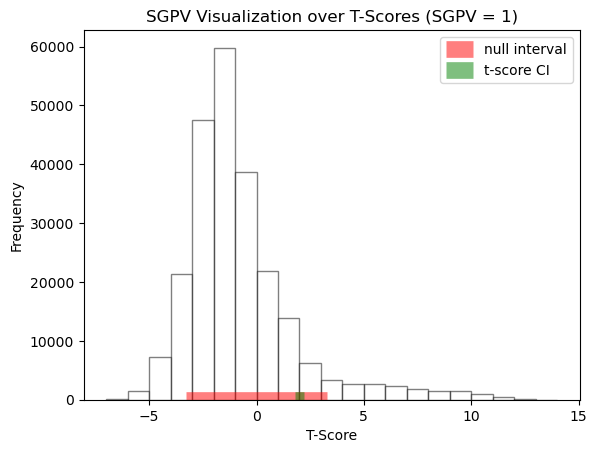

In [77]:
# Plot

# Flatten image data
spmT_img = spmT.flatten()

# Plot T-scores not 0
spmT_img_0 = [x for x in spmT_img if x != 0]

# Create the histogram
bin_edges = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.hist(spmT_img_0, bins=bin_edges, color='white', edgecolor='black', alpha=0.5)

# Add horizontal lines spanning -3 to 3 and -2 to 2 at y=0
plt.hlines(y=0, xmin=-3.291, xmax=3.291, colors='red', linewidth=12, label='null interval', alpha=0.5)
plt.hlines(y=0.5, xmin=ci_lower, xmax=ci_upper, colors='green', linewidth=12, label='t-score CI', alpha=0.5)

# Add labels and title
plt.xlabel('T-Score')
plt.ylabel('Frequency')
plt.title('SGPV Visualization over T-Scores (SGPV = 1)')

# Add legend
plt.legend()

# Show the plot
plt.show()

# SGPV = Partial Support for Null Hypothesis

In [78]:
ci_lower, ci_upper = calculate_second_gen_p_value(observed_effect = 3.2, #t value
                            null_hypothesis = 0, 
                            effect_interval = 3.291, #99.9% CI of t distribution with inf subjects
                            n = subjects, 
                            alpha = alpha, 
                            df = 1, #1 -tailed
                            verbose=True)

N: 200
alpha: 0.001
df: 1
T-score: 3.2
SD: 3.090232306167813
SE: 0.21906076009519282
Confidence Interval: [2.9809392399048074,3.419060760095193]

Null Hypothesis: 0
Effect Interval Test Value: 3.291
Null Interval: [-3.291,3.291]

Second Gen p-value: 0.70770493072437
Interpretation: Partial evidence, some consistency with null


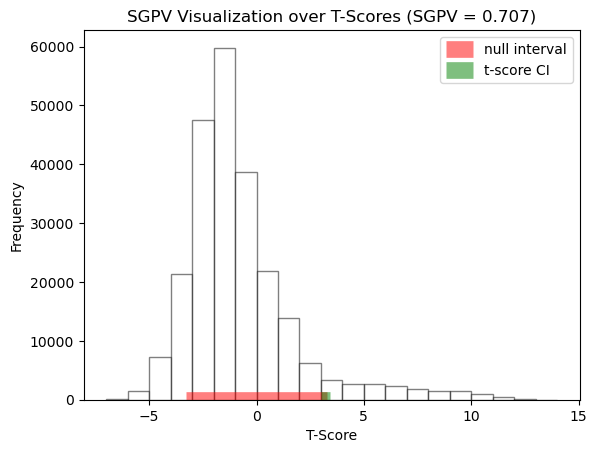

In [79]:
# Plot

# Flatten image data
spmT_img = spmT.flatten()

# Plot T-scores not 0
spmT_img_0 = [x for x in spmT_img if x != 0]

# Create the histogram
bin_edges = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.hist(spmT_img_0, bins=bin_edges, color='white', edgecolor='black', alpha=0.5)

# Add horizontal lines spanning -3 to 3 and -2 to 2 at y=0
plt.hlines(y=0, xmin=-3.291, xmax=3.291, colors='red', linewidth=12, label='null interval', alpha=0.5)
plt.hlines(y=0.5, xmin=ci_lower, xmax=ci_upper, colors='green', linewidth=12, label='t-score CI', alpha=0.5)

# Add labels and title
plt.xlabel('T-Score')
plt.ylabel('Frequency')
plt.title('SGPV Visualization over T-Scores (SGPV = 0.707)')

# Add legend
plt.legend()

# Show the plot
plt.show()

# SGPV = Reject Null Hypothesis

In [80]:
ci_lower, ci_upper = calculate_second_gen_p_value(observed_effect = 4, #t value
                            null_hypothesis = 0, 
                            effect_interval = 3.291, #99.9% CI of t distribution with inf subjects
                            n = subjects, 
                            alpha = alpha, 
                            df = 1, #1 -tailed
                            verbose=True)

N: 200
alpha: 0.001
df: 1
T-score: 4
SD: 3.090232306167813
SE: 0.21906076009519282
Confidence Interval: [3.780939239904807,4.219060760095193]

Null Hypothesis: 0
Effect Interval Test Value: 3.291
Null Interval: [-3.291,3.291]

Second Gen p-value: 0.0
Interpretation: The data supports an alternative hypothesis that is scientifically OR clinically meaningful


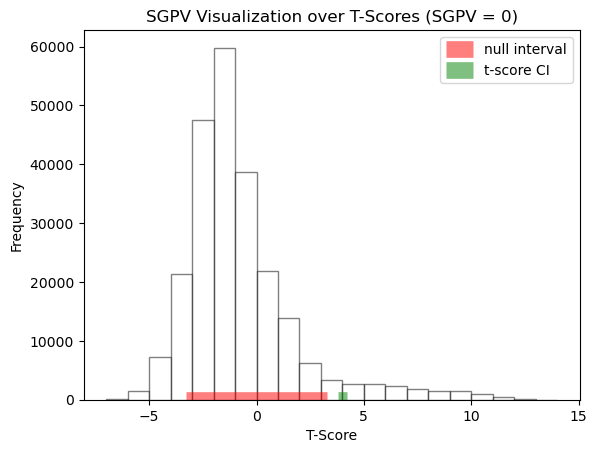

In [81]:
# Plot

# Flatten image data
spmT_img = spmT.flatten()

# Plot T-scores not 0
spmT_img_0 = [x for x in spmT_img if x != 0]

# Create the histogram
bin_edges = [-7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
plt.hist(spmT_img_0, bins=bin_edges, color='white', edgecolor='black', alpha=0.5)

# Add horizontal lines spanning -3 to 3 and -2 to 2 at y=0
plt.hlines(y=0, xmin=-3.291, xmax=3.291, colors='red', linewidth=12, label='null interval', alpha=0.5)
plt.hlines(y=0.5, xmin=ci_lower, xmax=ci_upper, colors='green', linewidth=12, label='t-score CI', alpha=0.5)

# Add labels and title
plt.xlabel('T-Score')
plt.ylabel('Frequency')
plt.title('SGPV Visualization over T-Scores (SGPV = 0)')

# Add legend
plt.legend()

# Show the plot
plt.show()